In [23]:
# import networkx as nx
# from parse import read_input_file, write_output_file
# from utils import is_valid_network, average_pairwise_distance
# import os
# import sys
# import matplotlib.pyplot as plt
# import random
# import utils


# def solve(G):
#     """
#     Args:
#         G: networkx.Graph

#     Returns:
#         T: networkx.Graph
#     """

#     T = nx.minimum_spanning_tree(G)
#     if T.number_of_nodes() == 1:
#         return T
#     elif T.number_of_nodes() == 2:
#         node = list(T.nodes)[0]
#         T.remove_node(node)
#         return T
#     else:
#         u_list = []
#         v_list = []
#         v_u_dict = {node:[] for node in T.nodes}
#         for u in T.nodes:
#             if T.degree(u) == 1:
#                 v = list(T.neighbors(u))[0]
#                 u_list.append(u)
#                 v_list.append(v)
#                 v_u_dict[v].append(u)
#         for u in u_list:
#             T.remove_node(u)
#         if len(list(T.nodes)) == 1:
#             return T
#         v_list = list(set(v_list))
#         for v in v_list:
#             copy = T.copy()
#             copy.remove_node(v)
#             if len(list(copy.nodes)) == 0:
#                 return T
#             if is_valid_network(G, copy):
#                 T.remove_node(v)
        
#         # newly added: brute force final deletion check
#         # node_list = list(T.nodes())
#         # for node in node_list:
#         #     copy = T.copy()
#         #     copy.remove_node(node)
#         #     if len(list(copy.nodes)) == 0:
#         #         return T
#         #     if is_valid_network(G, copy):
#         #         T.remove_node(node)
        
#         min_T = T.copy()
#         for i in range(300):
#             copy = T.copy()
#             while is_valid_network(G, copy):
#                 T = copy.copy()
#                 node_list = list(T.nodes())
#                 n = random.choice(node_list)
#                 copy.remove_node(n)

#                 if len(list(copy.nodes)) == 0:
#                     return T
#                 if is_valid_network(G, copy):
#                     if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
#                         min_T = copy.copy()
        
#         return min_T
#         # TODO: your code here!
    


# # Here's an example of how to run your solver.

# # Usage: python3 solver.py test.in

# if __name__ == '__main__':

#     input_folder_path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs'
#     for input_file in os.listdir(input_folder_path):
#         print(input_file)
#         full_path = os.path.join(input_folder_path, input_file)
#         G = read_input_file(full_path)
#         T = solve(G)
#         assert is_valid_network(G, T), "T is not a valid network of G."
#         print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#         write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + input_file[:-2] + 'out')

#     # path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs/large-26.in'
#     # G = read_input_file(path)
#     # T = solve(G)
#     # fig = plt.figure(figsize=(20,30))
#     # fig.add_subplot(211)
#     # pos = nx.spring_layout(G)
#     # nx.draw_networkx(G, pos=pos, node_color='yellow')
#     # nx.draw_networkx(G.subgraph(T.nodes()), pos=pos, node_color='orange', edge_color='red')
#     # assert is_valid_network(G, T), "T is not a valid network of G."
#     # print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#     # write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + path[-10:-2] + 'out')


# below is the method using degree heuristic to let MST pick higher-degree nodes

import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np


def solve(G):
    """
    Args:
        G: networkx.Graph

    Returns:
        T: networkx.Graph
    """
    # added: weight <- weight - degree, to let MST choose higher-degree nodes
    G_copy = G.copy()
    for edge in G_copy.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] /= np.log(1+max(G_copy.degree(u), G_copy.degree(v)))
    T = nx.minimum_spanning_tree(G_copy)
    for edge in T.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] = G[u][v]['weight']
        
    # Add in nodes with eccentricity lower than T's radius to possibly reduce the longest distance between 2 endpoints
    for node in G.nodes():
        if nx.eccentricity(T, node) < nx.radius(T):
            T.add_node(node)
            e = min(G.edges(node), key=lambda x: G[x[0]][x[1]]['weight'])
            T.add_edge(e[0],e[1])
    
    if T.number_of_nodes() == 1:
        return T
    elif T.number_of_nodes() == 2:
        node = list(T.nodes)[0]
        T.remove_node(node)
        return T
    else:
        u_list = []
        v_list = []
        v_u_dict = {node:[] for node in T.nodes}
        for u in T.nodes:
            if T.degree(u) == 1:
                v = list(T.neighbors(u))[0]
                u_list.append(u)
                v_list.append(v)
                v_u_dict[v].append(u)
        for u in u_list:
            T.remove_node(u)
        if len(list(T.nodes)) == 1:
            return T
        v_list = list(set(v_list))
        for v in v_list:
            copy = T.copy()
            copy.remove_node(v)
            if len(list(copy.nodes)) == 0:
                return T
            if is_valid_network(G, copy):
                T.remove_node(v)
        
        # newly added: brute force final deletion check
#         node_list = list(T.nodes())
#         for node in node_list:
#             copy = T.copy()
#             copy.remove_node(node)
#             if len(list(copy.nodes)) == 0:
#                 return T
#             if is_valid_network(G, copy):
#                 T.remove_node(node)
        min_T = T.copy()
        for i in range(300):
            copy = T.copy()
            while is_valid_network(G, copy):
                T = copy.copy()
                node_list = list(T.nodes())
                n = random.choices(node_list, weights=[0.001 + np.log(nx.eccentricity(T, x)) for x in node_list])[0]
                copy.remove_node(n)

                if len(list(copy.nodes)) == 0:
                    return T
                if is_valid_network(G, copy):
                    if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
                        min_T = copy.copy()
                        
                        
        # added
#         min_T.remove_edge(20, 21)
#         min_T.add_edge(13, 17)
        
        return min_T
        # TODO: your code here!
    


# Here's an example of how to run your solver.

# Usage: python3 solver.py test.in

if __name__ == '__main__':

    input_folder_path = 'inputs'
    for input_file in os.listdir(input_folder_path):
        print(input_file)
        full_path = os.path.join(input_folder_path, input_file)
        G = read_input_file(full_path)
        T = solve(G)
        assert is_valid_network(G, T), "T is not a valid network of G."
        # Compare previous result with new result, update if improvement seen
        old = read_output_file('outputs/' + input_file[:-2] + 'out', G)
        dist_old = average_pairwise_distance_fast(old)
        dist_new = average_pairwise_distance_fast(T)
        print("Old Average  pairwise distance: {}".format(dist_old))
        print("New Average  pairwise distance: {}".format(dist_new))
        if dist_old > dist_new:
            write_output_file(T, 'outputs/' + input_file[:-2] + 'out')

#     path = 'inputs/large-10.in'
#     G = read_input_file(path)
#     T = solve(G)
#     fig = plt.figure(figsize=(20,30))
#     fig.add_subplot(211)
#     pos = nx.spring_layout(G)
    
#     labels = nx.get_edge_attributes(G,'weight')
    
#     nx.draw_networkx(G, pos=pos, node_color='yellow')
#     nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='orange', edge_color='yellow')
#     # nx.draw_networkx(T, pos=pos, node_color='yellow')
#     #nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#     assert is_valid_network(G, T), "T is not a valid network of G."
#     print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#     write_output_file(T, 'outputs/' + path[-10:-2] + 'out')
        
    
    
    


large-1.in
Old Average  pairwise distance: 62.40203761755486
New Average  pairwise distance: 62.40203761755486
large-10.in
Old Average  pairwise distance: 3.206952380952381
New Average  pairwise distance: 4.334428571428571
large-100.in
Old Average  pairwise distance: 99.9
New Average  pairwise distance: 99.9
large-101.in
Old Average  pairwise distance: 34.5668253968254
New Average  pairwise distance: 34.5668253968254
large-102.in


<ipython-input-23-a5142b370bca>:191: RuntimeWarning: divide by zero encountered in log
  n = random.choices(node_list, weights=[np.log(nx.eccentricity(T, x)) for x in node_list])[0]


Old Average  pairwise distance: 0
New Average  pairwise distance: 0
large-103.in
Old Average  pairwise distance: 1.5582
New Average  pairwise distance: 0.9171666666666667
large-104.in
Old Average  pairwise distance: 28.345857142857145
New Average  pairwise distance: 26.223744615384618
large-105.in
Old Average  pairwise distance: 2.719666666666667
New Average  pairwise distance: 5.806055555555555
large-106.in
Old Average  pairwise distance: 32.140181818181816
New Average  pairwise distance: 32.140181818181816
large-107.in
Old Average  pairwise distance: 33.0
New Average  pairwise distance: 33.0
large-108.in
Old Average  pairwise distance: 2.7384
New Average  pairwise distance: 4.890466666666668
large-109.in
Old Average  pairwise distance: 50.8187134502924
New Average  pairwise distance: 10.0
large-11.in
Old Average  pairwise distance: 87.53411764705882
New Average  pairwise distance: 81.62585034013605
large-110.in
Old Average  pairwise distance: 5.0
New Average  pairwise distance: 5.0
l

Old Average  pairwise distance: 7.341075268817205
New Average  pairwise distance: 7.440919540229883
large-173.in
Old Average  pairwise distance: 395.3887957393484
New Average  pairwise distance: 395.3887957393484
large-174.in
Old Average  pairwise distance: 184.16860215053762
New Average  pairwise distance: 159.64387096774192
large-175.in
Old Average  pairwise distance: 1519.4802581527458
New Average  pairwise distance: 1519.4802581527458
large-176.in
Old Average  pairwise distance: 14.425
New Average  pairwise distance: 14.455882352941176
large-177.in
Old Average  pairwise distance: 0.29969960474308294
New Average  pairwise distance: 0.294073593073593
large-178.in
Old Average  pairwise distance: 12.706410256410257
New Average  pairwise distance: 12.410975609756097
large-179.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
large-18.in
Old Average  pairwise distance: 220.46856168359938
New Average  pairwise distance: 230.21127812718376
large-180.in
Old Average  pai

Old Average  pairwise distance: 0
New Average  pairwise distance: 0
large-241.in
Old Average  pairwise distance: 10.594936708860759
New Average  pairwise distance: 13.329113924050633
large-242.in
Old Average  pairwise distance: 513.9834084124831
New Average  pairwise distance: 523.6388144927536
large-243.in
Old Average  pairwise distance: 48.10476190476191
New Average  pairwise distance: 48.099567099567096
large-244.in
Old Average  pairwise distance: 12.070175438596491
New Average  pairwise distance: 12.070175438596491
large-245.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
large-246.in
Old Average  pairwise distance: 163.62702702702703
New Average  pairwise distance: 143.9244264507422
large-247.in
Old Average  pairwise distance: 23.387921022067363
New Average  pairwise distance: 24.89429175475687
large-248.in
Old Average  pairwise distance: 1696.5438670313483
New Average  pairwise distance: 1696.5438670313483
large-249.in
Old Average  pairwise distance: 16.333

Old Average  pairwise distance: 34.58714634146341
New Average  pairwise distance: 53.69150871080139
large-31.in
Old Average  pairwise distance: 557.4712573496156
New Average  pairwise distance: 528.5598098891728
large-310.in
Old Average  pairwise distance: 36.72240666666667
New Average  pairwise distance: 33.00488537549408
large-311.in
Old Average  pairwise distance: 42.24601079622132
New Average  pairwise distance: 41.744506401138
large-312.in
Old Average  pairwise distance: 36.706761904761905
New Average  pairwise distance: 41.74199999999999
large-313.in
Old Average  pairwise distance: 50.955586206896555
New Average  pairwise distance: 50.630171957671955
large-314.in
Old Average  pairwise distance: 40.156379084967334
New Average  pairwise distance: 39.97883006535949
large-315.in
Old Average  pairwise distance: 47.14276113360325
New Average  pairwise distance: 49.40972972972972
large-316.in
Old Average  pairwise distance: 40.851966777408634
New Average  pairwise distance: 64.665666666

Old Average  pairwise distance: 137.77487755102038
New Average  pairwise distance: 126.0781462585034
large-376.in
Old Average  pairwise distance: 114.9243182238668
New Average  pairwise distance: 117.80610971348707
large-377.in
Old Average  pairwise distance: 143.60166214689266
New Average  pairwise distance: 113.81371052631576
large-378.in
Old Average  pairwise distance: 124.8257857142857
New Average  pairwise distance: 127.32010342417888
large-379.in
Old Average  pairwise distance: 142.4899047619048
New Average  pairwise distance: 104.25399624060145
large-38.in
Old Average  pairwise distance: 147.85645074224018
New Average  pairwise distance: 108.80003025210084
large-380.in
Old Average  pairwise distance: 101.64874132730017
New Average  pairwise distance: 105.02388388969513
large-381.in
Old Average  pairwise distance: 119.0905901360544
New Average  pairwise distance: 133.92942356902356
large-382.in
Old Average  pairwise distance: 136.07516110304792
New Average  pairwise distance: 135

Old Average  pairwise distance: 57.53092391304349
New Average  pairwise distance: 62.665859999999995
large-83.in
Old Average  pairwise distance: 13.617862745098035
New Average  pairwise distance: 13.053009523809521
large-84.in
Old Average  pairwise distance: 5.409999999999999
New Average  pairwise distance: 3.4999999999999996
large-85.in
Old Average  pairwise distance: 2.2
New Average  pairwise distance: 2.4
large-86.in
Old Average  pairwise distance: 12.319777777777777
New Average  pairwise distance: 10.410555555555556
large-87.in
Old Average  pairwise distance: 337.5871299790357
New Average  pairwise distance: 337.5871299790357
large-88.in
Old Average  pairwise distance: 1.58
New Average  pairwise distance: 1.12
large-89.in
Old Average  pairwise distance: 507.2579124579125
New Average  pairwise distance: 674.2395644283122
large-9.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
large-90.in
Old Average  pairwise distance: 1457.2337220702711
New Average  pairwise 

Old Average  pairwise distance: 7.2
New Average  pairwise distance: 11.80952380952381
medium-152.in
Old Average  pairwise distance: 77.6524104609929
New Average  pairwise distance: 77.6524104609929
medium-153.in
Old Average  pairwise distance: 76.79714285714287
New Average  pairwise distance: 76.79714285714287
medium-154.in
Old Average  pairwise distance: 6.432748538011696
New Average  pairwise distance: 6.038095238095238
medium-155.in
Old Average  pairwise distance: 127.23001904761902
New Average  pairwise distance: 66.39720467836257
medium-156.in
Old Average  pairwise distance: 69.22186666666667
New Average  pairwise distance: 82.54436764705882
medium-157.in
Old Average  pairwise distance: 48.92946198830409
New Average  pairwise distance: 48.92946198830409
medium-158.in
Old Average  pairwise distance: 23.055833333333336
New Average  pairwise distance: 22.094117647058823
medium-159.in
Old Average  pairwise distance: 0.4666666666666666
New Average  pairwise distance: 0.4666666666666666

Old Average  pairwise distance: 5.5878
New Average  pairwise distance: 5.5878
medium-22.in
Old Average  pairwise distance: 2.4364999999999997
New Average  pairwise distance: 3.2153333333333336
medium-220.in
Old Average  pairwise distance: 251.5810276679842
New Average  pairwise distance: 251.5810276679842
medium-221.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
medium-222.in
Old Average  pairwise distance: 48.1385090909091
New Average  pairwise distance: 30.346439393939395
medium-223.in
Old Average  pairwise distance: 35.15555555555556
New Average  pairwise distance: 33.163636363636364
medium-224.in
Old Average  pairwise distance: 561.2671631205675
New Average  pairwise distance: 561.2671631205675
medium-225.in
Old Average  pairwise distance: 53.72566666666667
New Average  pairwise distance: 54.21678048780487
medium-226.in
Old Average  pairwise distance: 60.862525
New Average  pairwise distance: 53.55481904761904
medium-227.in
Old Average  pairwise distance: 32

Old Average  pairwise distance: 264.9021164021164
New Average  pairwise distance: 266.3084677419355
medium-289.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
medium-29.in
Old Average  pairwise distance: 29.923000000000002
New Average  pairwise distance: 29.923000000000002
medium-290.in
Old Average  pairwise distance: 73.6952380952381
New Average  pairwise distance: 73.6952380952381
medium-291.in
Old Average  pairwise distance: 74.02272380952381
New Average  pairwise distance: 82.76725714285712
medium-292.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
medium-293.in
Old Average  pairwise distance: 5.134933333333333
New Average  pairwise distance: 5.134933333333333
medium-294.in
Old Average  pairwise distance: 22.676959064327487
New Average  pairwise distance: 24.771462450592885
medium-295.in
Old Average  pairwise distance: 149.24683760683757
New Average  pairwise distance: 133.55514942528737
medium-296.in
Old Average  pairwise distance: 13.

Old Average  pairwise distance: 38.80018333333333
New Average  pairwise distance: 26.37497777777778
medium-84.in
Old Average  pairwise distance: 7.85904761904762
New Average  pairwise distance: 2.058
medium-85.in
Old Average  pairwise distance: 6.2
New Average  pairwise distance: 6.2
medium-86.in
Old Average  pairwise distance: 14.870555555555557
New Average  pairwise distance: 16.25722222222222
medium-87.in
Old Average  pairwise distance: 195.72115999999997
New Average  pairwise distance: 195.72115999999997
medium-88.in
Old Average  pairwise distance: 2.57
New Average  pairwise distance: 3.3666666666666667
medium-89.in
Old Average  pairwise distance: 83.09982174688056
New Average  pairwise distance: 83.09072580645162
medium-9.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
medium-90.in
Old Average  pairwise distance: 614.7251888297874
New Average  pairwise distance: 614.7251888297874
medium-91.in
Old Average  pairwise distance: 5.9854
New Average  pairwise dista

Old Average  pairwise distance: 32.52566666666666
New Average  pairwise distance: 32.52566666666666
small-156.in
Old Average  pairwise distance: 107.22399999999999
New Average  pairwise distance: 71.7031212121212
small-157.in
Old Average  pairwise distance: 1.075
New Average  pairwise distance: 1.075
small-158.in
Old Average  pairwise distance: 4.279999999999999
New Average  pairwise distance: 4.279999999999999
small-159.in
Old Average  pairwise distance: 0.3333333333333333
New Average  pairwise distance: 0.3333333333333333
small-16.in
Old Average  pairwise distance: 198.01904761904763
New Average  pairwise distance: 198.01904761904763
small-160.in
Old Average  pairwise distance: 58.418333333333344
New Average  pairwise distance: 33.40964285714286
small-161.in
Old Average  pairwise distance: 10.395604395604396
New Average  pairwise distance: 10.045454545454545
small-162.in
Old Average  pairwise distance: 64.42366666666666
New Average  pairwise distance: 64.42366666666666
small-163.in
O

Old Average  pairwise distance: 99.48837944664031
New Average  pairwise distance: 99.48837944664031
small-225.in
Old Average  pairwise distance: 19.633750000000003
New Average  pairwise distance: 19.457352941176474
small-226.in
Old Average  pairwise distance: 74.68616666666667
New Average  pairwise distance: 47.86562222222222
small-227.in
Old Average  pairwise distance: 133.6
New Average  pairwise distance: 133.6
small-228.in
Old Average  pairwise distance: 45.75
New Average  pairwise distance: 45.75
small-229.in
Old Average  pairwise distance: 8.0
New Average  pairwise distance: 8.0
small-23.in
Old Average  pairwise distance: 1.8517857142857144
New Average  pairwise distance: 1.8517857142857144
small-230.in
Old Average  pairwise distance: 22.775757575757574
New Average  pairwise distance: 17.696969696969695
small-231.in
Old Average  pairwise distance: 118.4043956043956
New Average  pairwise distance: 114.77802197802197
small-232.in
Old Average  pairwise distance: 13.8022
New Average  

Old Average  pairwise distance: 11.397454545454545
New Average  pairwise distance: 5.500727272727273
small-3.in
Old Average  pairwise distance: 171.50879120879122
New Average  pairwise distance: 171.50879120879122
small-30.in
Old Average  pairwise distance: 35.46885714285714
New Average  pairwise distance: 32.93761111111111
small-300.in
Old Average  pairwise distance: 15.130666666666665
New Average  pairwise distance: 15.130666666666665
small-301.in
Old Average  pairwise distance: 85.80646153846152
New Average  pairwise distance: 77.72746153846153
small-302.in
Old Average  pairwise distance: 9.427333333333333
New Average  pairwise distance: 9.051833333333333
small-303.in
Old Average  pairwise distance: 0
New Average  pairwise distance: 0
small-31.in
Old Average  pairwise distance: 91.22243636363638
New Average  pairwise distance: 74.96583333333334
small-32.in
Old Average  pairwise distance: 1.5
New Average  pairwise distance: 1.5
small-33.in
Old Average  pairwise distance: 13.970256410

Old Average  pairwise distance: 4.890666666666667
New Average  pairwise distance: 1.896
small-99.in
Old Average  pairwise distance: 60.89527777777778
New Average  pairwise distance: 44.459357142857144


In [24]:
    temp = read_output_file('outputs/large-102.out', G)
    nx.draw_networkx(G, pos=pos, node_color='yellow')
    nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='orange', edge_color='yellow')
    print("Average  pairwise distance: {}".format(average_pairwise_distance(temp)))

AssertionError: 

Average  pairwise distance: 0


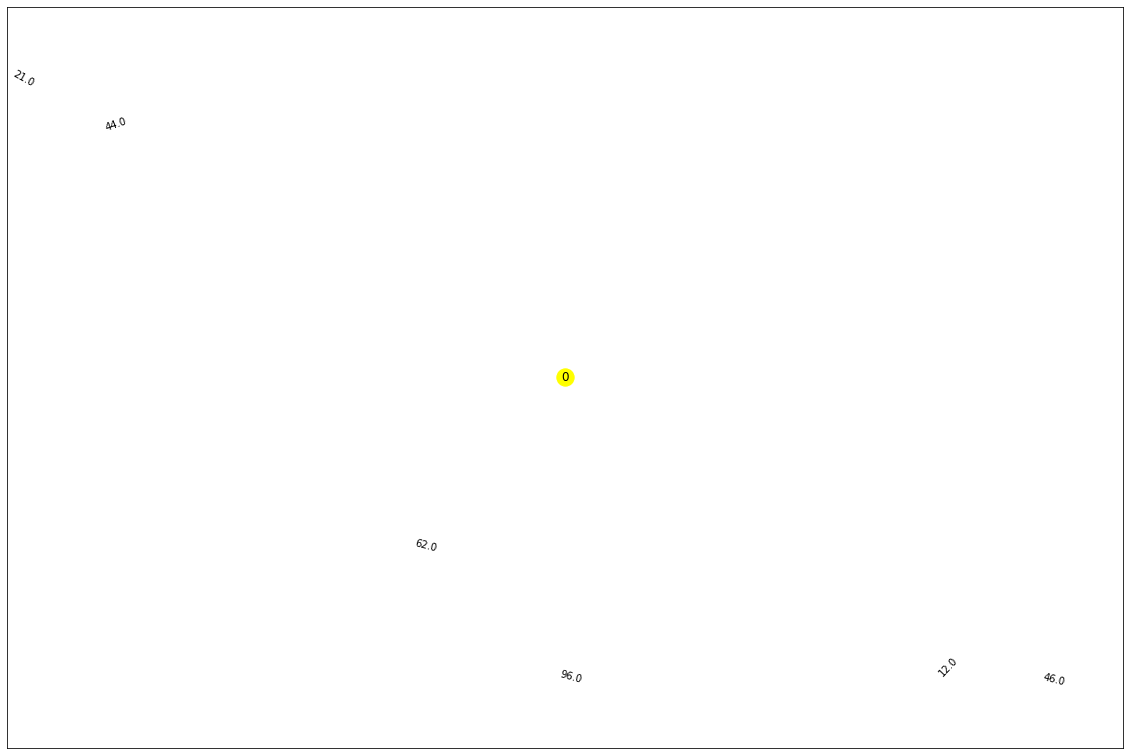

In [31]:
# import networkx as nx
# from parse import read_input_file, write_output_file
# from utils import is_valid_network, average_pairwise_distance
# import os
# import sys
# import matplotlib.pyplot as plt
# import random
# import utils


# def solve(G):
#     """
#     Args:
#         G: networkx.Graph

#     Returns:
#         T: networkx.Graph
#     """

#     T = nx.minimum_spanning_tree(G)
#     if T.number_of_nodes() == 1:
#         return T
#     elif T.number_of_nodes() == 2:
#         node = list(T.nodes)[0]
#         T.remove_node(node)
#         return T
#     else:
#         u_list = []
#         v_list = []
#         v_u_dict = {node:[] for node in T.nodes}
#         for u in T.nodes:
#             if T.degree(u) == 1:
#                 v = list(T.neighbors(u))[0]
#                 u_list.append(u)
#                 v_list.append(v)
#                 v_u_dict[v].append(u)
#         for u in u_list:
#             T.remove_node(u)
#         if len(list(T.nodes)) == 1:
#             return T
#         v_list = list(set(v_list))
#         for v in v_list:
#             copy = T.copy()
#             copy.remove_node(v)
#             if len(list(copy.nodes)) == 0:
#                 return T
#             if is_valid_network(G, copy):
#                 T.remove_node(v)
        
#         # newly added: brute force final deletion check
#         # node_list = list(T.nodes())
#         # for node in node_list:
#         #     copy = T.copy()
#         #     copy.remove_node(node)
#         #     if len(list(copy.nodes)) == 0:
#         #         return T
#         #     if is_valid_network(G, copy):
#         #         T.remove_node(node)
        
#         min_T = T.copy()
#         for i in range(300):
#             copy = T.copy()
#             while is_valid_network(G, copy):
#                 T = copy.copy()
#                 node_list = list(T.nodes())
#                 n = random.choice(node_list)
#                 copy.remove_node(n)

#                 if len(list(copy.nodes)) == 0:
#                     return T
#                 if is_valid_network(G, copy):
#                     if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
#                         min_T = copy.copy()
        
#         return min_T
#         # TODO: your code here!
    


# # Here's an example of how to run your solver.

# # Usage: python3 solver.py test.in

# if __name__ == '__main__':

#     input_folder_path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs'
#     for input_file in os.listdir(input_folder_path):
#         print(input_file)
#         full_path = os.path.join(input_folder_path, input_file)
#         G = read_input_file(full_path)
#         T = solve(G)
#         assert is_valid_network(G, T), "T is not a valid network of G."
#         print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#         write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + input_file[:-2] + 'out')

#     # path = '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/inputs/large-26.in'
#     # G = read_input_file(path)
#     # T = solve(G)
#     # fig = plt.figure(figsize=(20,30))
#     # fig.add_subplot(211)
#     # pos = nx.spring_layout(G)
#     # nx.draw_networkx(G, pos=pos, node_color='yellow')
#     # nx.draw_networkx(G.subgraph(T.nodes()), pos=pos, node_color='orange', edge_color='red')
#     # assert is_valid_network(G, T), "T is not a valid network of G."
#     # print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
#     # write_output_file(T, '/Users/chenpengyuan/Desktop/CS170/project-sp20-skeleton/outputs/' + path[-10:-2] + 'out')


# below is the method using degree heuristic to let MST pick higher-degree nodes

import networkx as nx
from parse import read_input_file, write_output_file, read_output_file
import utils
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import os
import sys
import matplotlib.pyplot as plt
import random
import numpy as np


def solve(G):
    """
    Args:
        G: networkx.Graph

    Returns:
        T: networkx.Graph
    """
    # added: weight <- weight - degree, to let MST choose higher-degree nodes
    G_copy = G.copy()
    for edge in G_copy.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] /= np.log(1+max(G_copy.degree(u), G_copy.degree(v)))
    T = nx.minimum_spanning_tree(G_copy)
    for edge in T.edges.data():
        u, v = edge[0], edge[1]
        edge[2]['weight'] = G[u][v]['weight']
        
    # Add in nodes with eccentricity lower than T's radius to possibly reduce the longest distance between 2 endpoints
    for node in G.nodes():
        if nx.eccentricity(T, node) < nx.radius(T):
            T.add_node(node)
            e = min(G.edges(node), key=lambda x: G[x[0]][x[1]]['weight'])
            T.add_edge(e[0],e[1])
    
    if T.number_of_nodes() == 1:
        return T
    elif T.number_of_nodes() == 2:
        node = list(T.nodes)[0]
        T.remove_node(node)
        return T
    else:
        u_list = []
        v_list = []
        v_u_dict = {node:[] for node in T.nodes}
        for u in T.nodes:
            if T.degree(u) == 1:
                v = list(T.neighbors(u))[0]
                u_list.append(u)
                v_list.append(v)
                v_u_dict[v].append(u)
        for u in u_list:
            T.remove_node(u)
        if len(list(T.nodes)) == 1:
            return T
        v_list = list(set(v_list))
        for v in v_list:
            copy = T.copy()
            copy.remove_node(v)
            if len(list(copy.nodes)) == 0:
                return T
            if is_valid_network(G, copy):
                T.remove_node(v)
        
        # newly added: brute force final deletion check
#         node_list = list(T.nodes())
#         for node in node_list:
#             copy = T.copy()
#             copy.remove_node(node)
#             if len(list(copy.nodes)) == 0:
#                 return T
#             if is_valid_network(G, copy):
#                 T.remove_node(node)
        min_T = T.copy()
        for i in range(300):
            copy = T.copy()
            while is_valid_network(G, copy):
                T = copy.copy()
                node_list = list(T.nodes())
                n = random.choices(node_list, weights=[np.log(1+nx.eccentricity(T, x)) for x in node_list])[0]
                copy.remove_node(n)

                if len(list(copy.nodes)) == 0:
                    return T
                if is_valid_network(G, copy):
                    if utils.average_pairwise_distance_fast(copy) < utils.average_pairwise_distance_fast(min_T):
                        min_T = copy.copy()
                        
                        
        # added
#         min_T.remove_edge(20, 21)
#         min_T.add_edge(13, 17)
        
        return min_T
        # TODO: your code here!
    


# Here's an example of how to run your solver.

# Usage: python3 solver.py test.in

if __name__ == '__main__':

#     input_folder_path = 'inputs'
#     for input_file in os.listdir(input_folder_path):
#         print(input_file)
#         full_path = os.path.join(input_folder_path, input_file)
#         G = read_input_file(full_path)
#         T = solve(G)
#         assert is_valid_network(G, T), "T is not a valid network of G."
#         # Compare previous result with new result, update if improvement seen
#         old = read_output_file('outputs/' + input_file[:-2] + 'out', G)
#         dist_old = average_pairwise_distance_fast(old)
#         dist_new = average_pairwise_distance_fast(T)
#         print("Old Average  pairwise distance: {}".format(dist_old))
#         print("New Average  pairwise distance: {}".format(dist_new))
#         if dist_old > dist_new:
#             write_output_file(T, 'outputs/' + input_file[:-2] + 'out')

    path = 'inputs/large-102.in'
    G = read_input_file(path)
    T = solve(G)
    fig = plt.figure(figsize=(20,30))
    fig.add_subplot(211)
    pos = nx.spring_layout(G)
    
    labels = nx.get_edge_attributes(G,'weight')
    
#     nx.draw_networkx(G, pos=pos, node_color='yellow')
#     nx.draw_networkx(G.edge_subgraph(T.edges()), pos=pos, node_color='red', edge_color='yellow')
#     nx.draw_networkx(T, pos=pos, node_color='yellow')
#     nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    assert is_valid_network(G, T), "T is not a valid network of G."
    print("Average  pairwise distance: {}".format(average_pairwise_distance(T)))
    write_output_file(T, 'outputs/' + path[-10:-2] + 'out')
        
    
    
    
